In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/baseline-submission/submission (15).csv
/kaggle/input/baseline-submission/submission (5).csv
/kaggle/input/baseline-submission/submission (19).csv
/kaggle/input/ristek-data-competition/sample_submission.csv
/kaggle/input/ristek-data-competition/train.csv
/kaggle/input/ristek-data-competition/test.csv


# **IMPORT NEEDED MODULE**

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from bayes_opt import BayesianOptimization
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
import optuna

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from optuna.samplers import TPESampler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from vecstack import stacking
from sklearn.decomposition import PCA
from catboost import EFeaturesSelectionAlgorithm

import warnings 
warnings.filterwarnings('ignore') 

print("Done")

Done


In [37]:
sampe_submission_df = pd.read_csv('/kaggle/input/ristek-data-competition/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/ristek-data-competition/train.csv')
test_df = pd.read_csv('/kaggle/input/ristek-data-competition/test.csv')
train_df.head()


,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0


## Data Preprocessing


In [38]:
#Mengubah timestamp ke datetime format, lalu mengambil jam
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['jam'] = train_df['timestamp'].dt.hour
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['jam'] = test_df['timestamp'].dt.hour
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20355 entries, 0 to 20354
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      20355 non-null  datetime64[ns]
 1   api_calls      20355 non-null  float64       
 2   clouds         20163 non-null  float64       
 3   distance_max   20355 non-null  float64       
 4   distance_mean  20355 non-null  float64       
 5   distance_min   20355 non-null  float64       
 6   humidity       20163 non-null  float64       
 7   price_mean     20355 non-null  float64       
 8   rain           20163 non-null  float64       
 9   surge_max      20355 non-null  float64       
 10  surge_mean     20355 non-null  float64       
 11  surge_min      20355 non-null  float64       
 12  temp           20163 non-null  float64       
 13  wind           20163 non-null  float64       
 14  type           20355 non-null  int64         
 15  jam            2035

In [39]:
train_df.describe()

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,jam
count,20355,20355.000000,20163.000000,20355.000000,20355.000000,20355.000000,20163.000000,20355.000000,20163.000000,20355.000000,20355.000000,20355.000000,20163.000000,20163.000000,20355.000000,20355.000000
mean,2018-12-01 18:57:20.294768128,14.092115,0.632140,3.568694,2.184314,1.013668,0.746397,19.339958,0.006013,1.201756,1.023335,1.000135,39.371818,5.935025,47.487055,11.733825
min,2018-11-26 06:00:00,1.000000,0.000000,0.030000,0.030000,0.020000,0.460000,3.000000,0.000000,1.000000,1.000000,1.000000,19.620000,0.300000,0.000000,0.000000
25%,2018-11-28 16:00:00,10.000000,0.366667,2.730000,1.767753,0.580000,0.630000,11.528783,0.000000,1.000000,1.000000,1.000000,35.720000,2.940000,23.000000,6.000000
50%,2018-11-30 21:00:00,12.000000,0.700000,3.300000,2.130000,1.010000,0.725000,19.000000,0.000000,1.000000,1.000000,1.000000,40.255000,5.120000,47.000000,12.000000
75%,2018-12-03 02:00:00,16.000000,0.955000,4.420000,2.642250,1.360000,0.890000,27.384615,0.000000,1.250000,1.031250,1.000000,44.160000,9.145000,71.000000,18.000000
max,2018-12-13 23:00:00,53.000000,1.000000,7.500000,6.090000,6.090000,0.990000,55.000000,0.359825,3.000000,1.535714,1.500000,55.410000,16.570000,95.000000,23.000000
std,NaN,7.142117,0.335760,1.111966,0.608937,0.499438,0.138612,8.944272,0.029570,0.321025,0.043062,0.007224,7.124324,3.474684,27.707571,6.922705


In [40]:
# Get names of columns with missing values
train_df_cols_with_missing = [col for col in train_df.columns
                     if train_df[col].isnull().any()]

test_df_cols_with_missing = [col for col in test_df.columns
                     if test_df[col].isnull().any()]

display(train_df_cols_with_missing)
display(test_df_cols_with_missing)

['clouds', 'humidity', 'rain', 'temp', 'wind']

[]

In [41]:
data_stat = pd.DataFrame()
data_stat.index = train_df.columns
data_stat["missing_sum"] = train_df.isna().sum()
data_stat["missing_rate"] = train_df.isna().mean()
data_stat["dtype"] = train_df.dtypes
data_stat

,missing_sum,missing_rate,dtype
timestamp,0,0.000000,datetime64[ns]
api_calls,0,0.000000,float64
clouds,192,0.009433,float64
distance_max,0,0.000000,float64
distance_mean,0,0.000000,float64
distance_min,0,0.000000,float64
humidity,192,0.009433,float64
price_mean,0,0.000000,float64
rain,192,0.009433,float64
surge_max,0,0.000000,float64


## Modelling

In [42]:
models = {
    'linear_regression': linear_model.LinearRegression(),
    'Huber_regression' : linear_model.HuberRegressor(),
    'lasso': linear_model.LassoCV(),
    'ridge': linear_model.RidgeCV(),
    'svr': svm.SVR(),
    'randomforest': ensemble.RandomForestRegressor(),
    'gradientboosting': ensemble.GradientBoostingRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'catboost': cb.CatBoostRegressor(verbose=0),
    'lightgbm': lgbm.LGBMRegressor(), 
    'MLPRegression' : MLPRegressor(), 
    'AdaBoostReg' : ensemble.AdaBoostRegressor(),
    'ExtraTreesReg' : ensemble.ExtraTreesRegressor()
}

In [43]:
def model_comparison(X_train, X_val, y_train, y_val, models):
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        score = mse(y_val, predictions, squared=False)
        print(f'{name}: {score}')

In [44]:
def kfold_cv(model, X, y):
    kf = KFold(n_splits=5)
    scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        rmse_score = mse(y_val, predictions, squared=False)
        scores.append(rmse_score)

    return np.mean(scores)

In [45]:
def model_cv_comparison(x, y, models):
    for name, model in models.items():
        score = kfold_cv(model, x, y)
        print(f'{name}: {score}')

In [46]:
interpolataion_method = ['polynomial', 'spline', 
                         'barycentric', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline', 'from_derivatives'
                        ]
# #Niatnya mau bikin fungsi buat nyari fungsi interpolasi terbaik
def find_best_interpolation(train_df, interpolataion_method,train_df_cols_with_missing):
    for method in interpolataion_method:
        if method == 'polynomial' or method == 'spline':
            order = [1,2,3]
            for orde in order:
                tes = train_df.copy()
                for missing in train_df_cols_with_missing:
                    tes[missing].interpolate(method= method, 
                                              order = orde, 
                                              inplace=True)
                    
                model = cb.CatBoostRegressor(verbose=0)
                x = tes.drop(columns = ['timestamp', 'price_mean'])
                y = tes.price_mean
                score = kfold_cv(model, x, y)
                print(f'{method} {orde} : {score}')
                
            
        else:
            tes = train_df.copy()
            for missing in train_df_cols_with_missing:
                tes[missing].interpolate(method= method,
                                          inplace=True)
                
            model = cb.CatBoostRegressor(verbose=0)
            x = tes.drop(columns = ['timestamp', 'price_mean'])
            y = tes.price_mean
            score = kfold_cv(model, x, y)
            print(f'{method} : {score}')

#find_best_interpolation(train_df, interpolataion_method, train_df_cols_with_missing)
#polynomial 1 : 7.281010621658406
#polynomial 2 : 7.276852463101628
#polynomial 3 : 7.286957716644125
#spline 1 : 7.291564026837409
#spline 2 : 7.266763374869498
#spline 3 : 7.2577835975473
#barycentric : 7.27381117994868
#piecewise_polynomial : 7.281010621658406
#pchip : 7.287426128527284
#akima : 7.263205637113643
#cubicspline : 7.286957716644125
#from_derivatives : 7.281010621658406

In [47]:
def impute(df, missing_cols, method):
    for missing in missing_cols:
        df[missing].interpolate(method= method, 
                                 order = 3, 
                                 inplace=True)
    return df
train_df = impute(train_df, train_df_cols_with_missing, 'spline')
train_df

,timestamp,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_mean,rain,surge_max,surge_mean,surge_min,temp,wind,type,jam
0,2018-11-26 06:00:00,9.0,0.990667,3.03,1.726667,1.04,0.913333,16.555556,0.0,1.50,1.055556,1.0,40.627333,1.350667,0,6
1,2018-11-26 07:00:00,10.0,0.970000,2.67,1.690000,1.09,0.920000,17.300000,0.0,2.00,1.100000,1.0,41.137500,1.735000,0,7
2,2018-11-26 08:00:00,1.0,0.980000,1.38,1.380000,1.38,0.923333,13.500000,0.0,1.00,1.000000,1.0,40.920000,1.330000,0,8
3,2018-11-26 09:00:00,11.0,1.000000,3.08,1.920909,1.39,0.927500,17.954545,0.0,1.75,1.113636,1.0,40.937500,1.365000,0,9
4,2018-11-26 10:00:00,12.0,0.995000,3.01,2.122500,1.07,0.940000,18.625000,0.0,1.50,1.083333,1.0,40.695000,1.895000,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20350,2018-12-13 19:00:00,13.0,0.510000,3.39,2.307692,0.72,0.570000,31.115385,0.0,1.00,1.000000,1.0,32.630000,1.840000,95,19
20351,2018-12-13 20:00:00,9.0,0.590000,2.80,1.902222,0.72,0.620000,28.833333,0.0,1.00,1.000000,1.0,32.100000,1.390000,95,20
20352,2018-12-13 21:00:00,16.0,0.760000,3.08,1.987500,0.72,0.630000,29.625000,0.0,1.00,1.000000,1.0,31.500000,2.030000,95,21
20353,2018-12-13 22:00:00,9.0,0.830000,3.08,2.441111,1.23,0.640000,30.500000,0.0,1.00,1.000000,1.0,31.180000,2.310000,95,22


## EDA

<Axes: xlabel='type', ylabel='price_mean'>

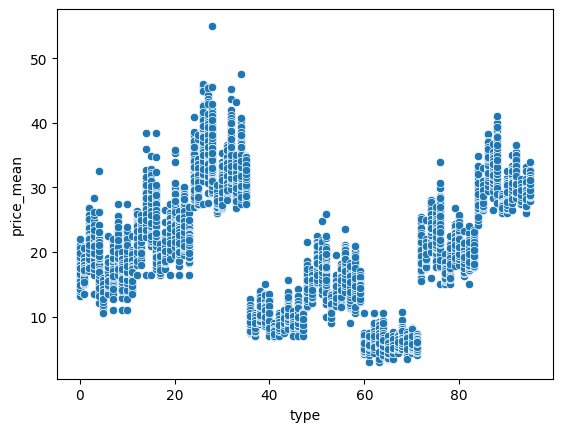

In [48]:
sns.scatterplot(data=train_df, x='type', y='price_mean')

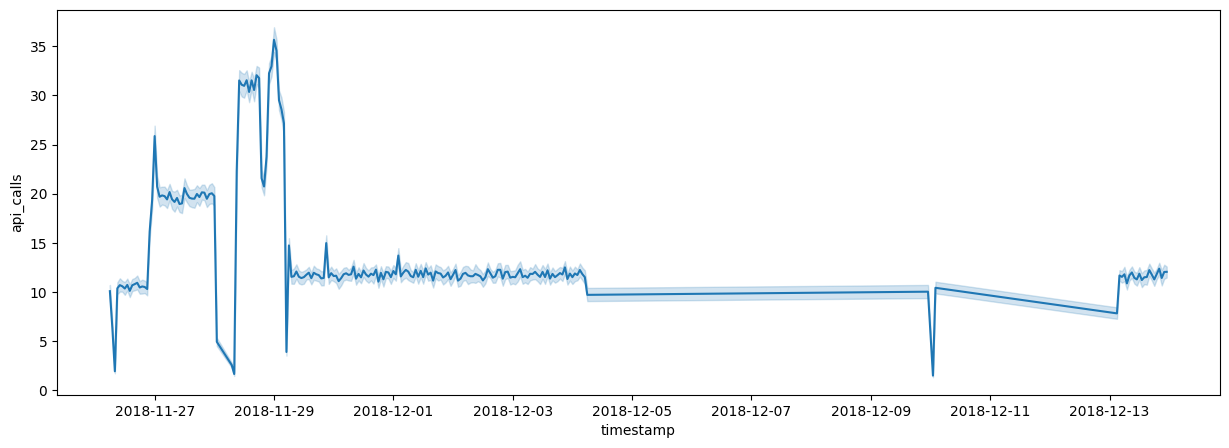

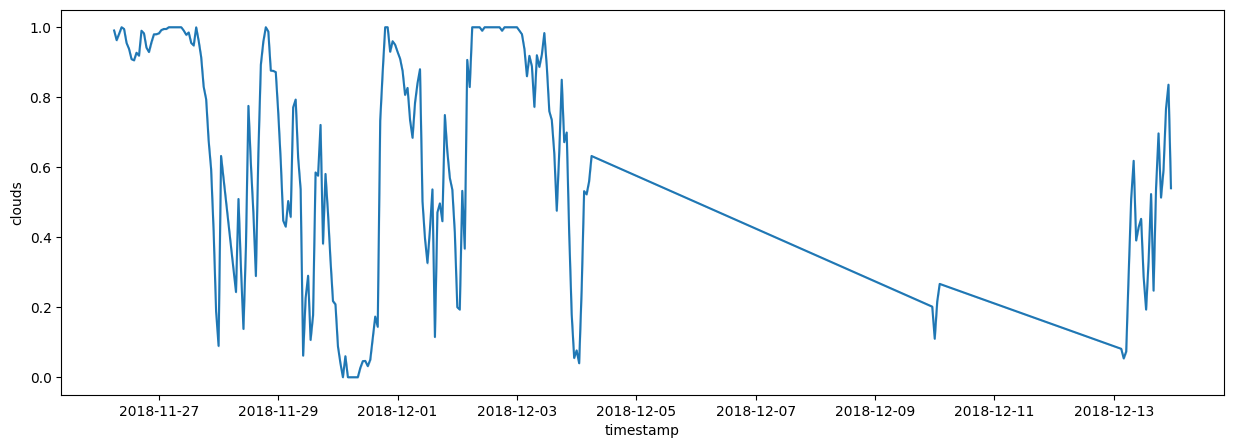

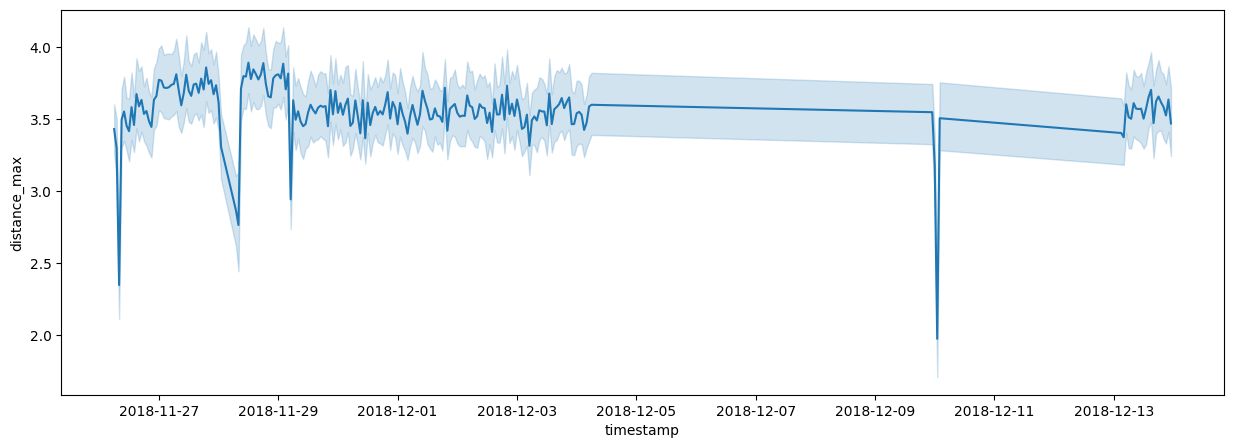

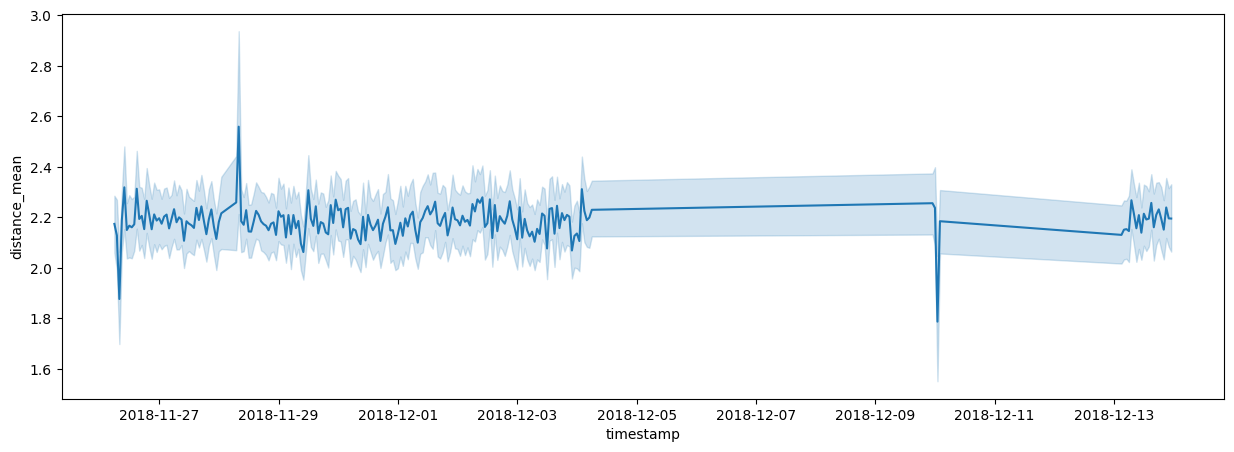

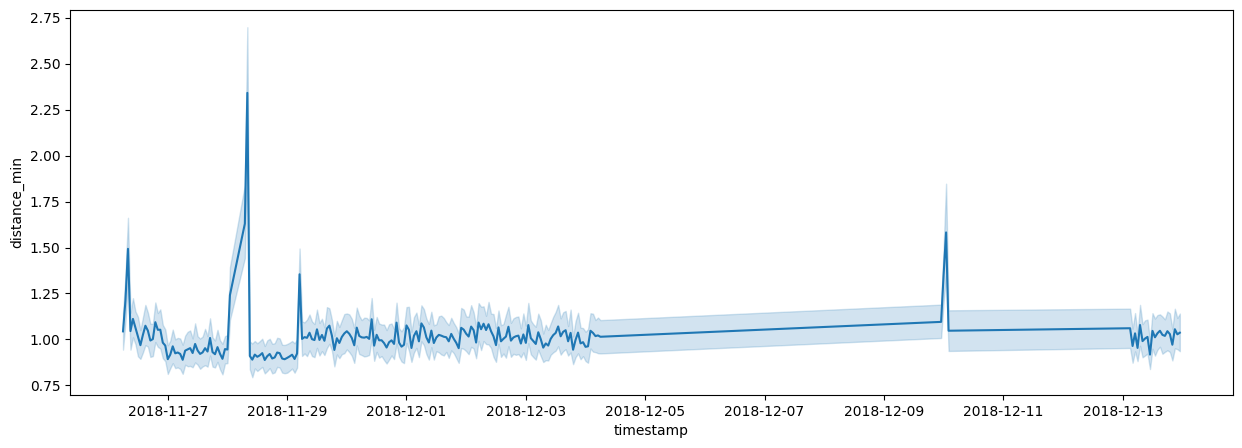

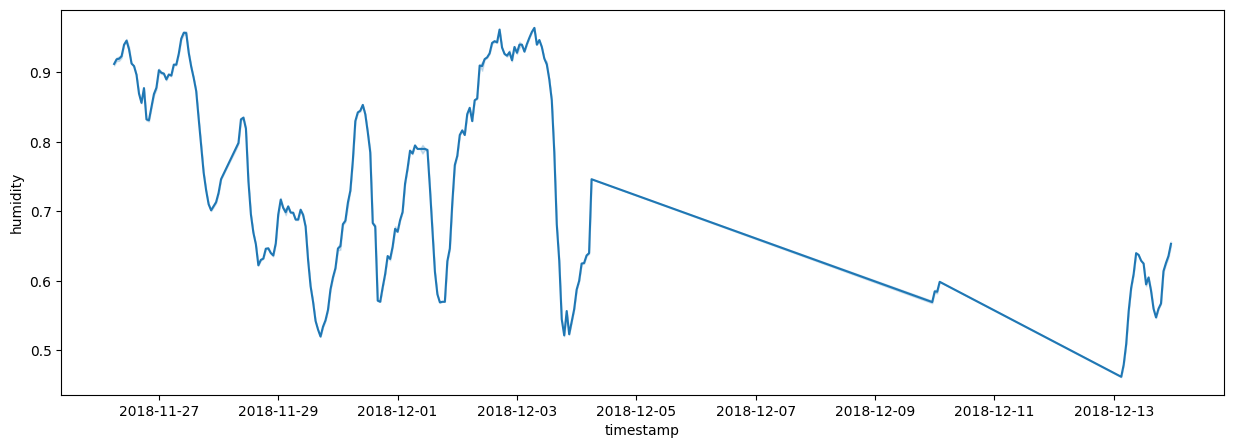

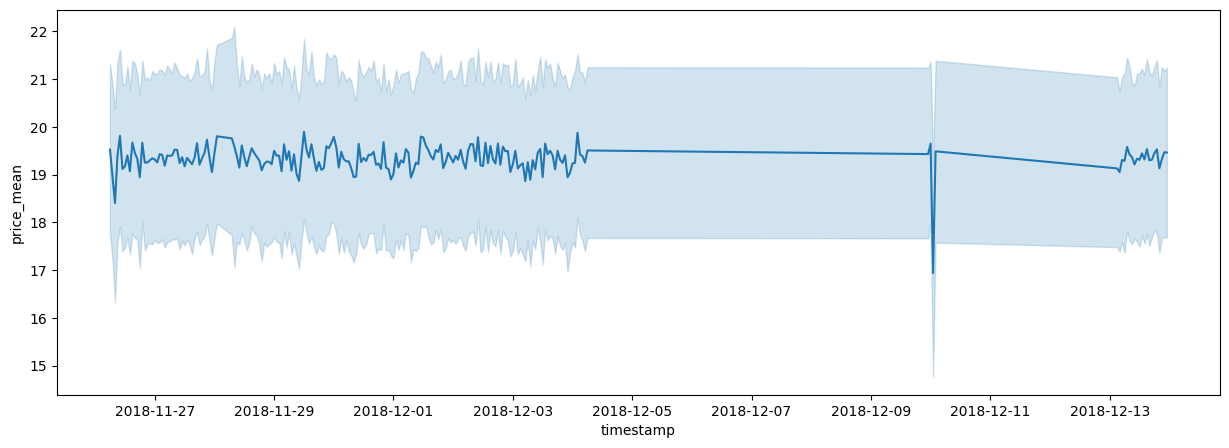

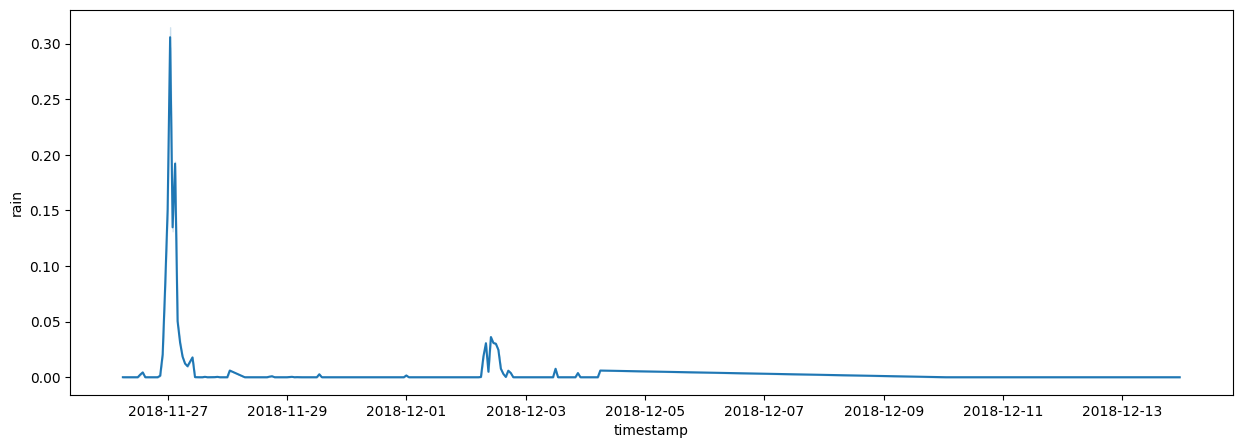

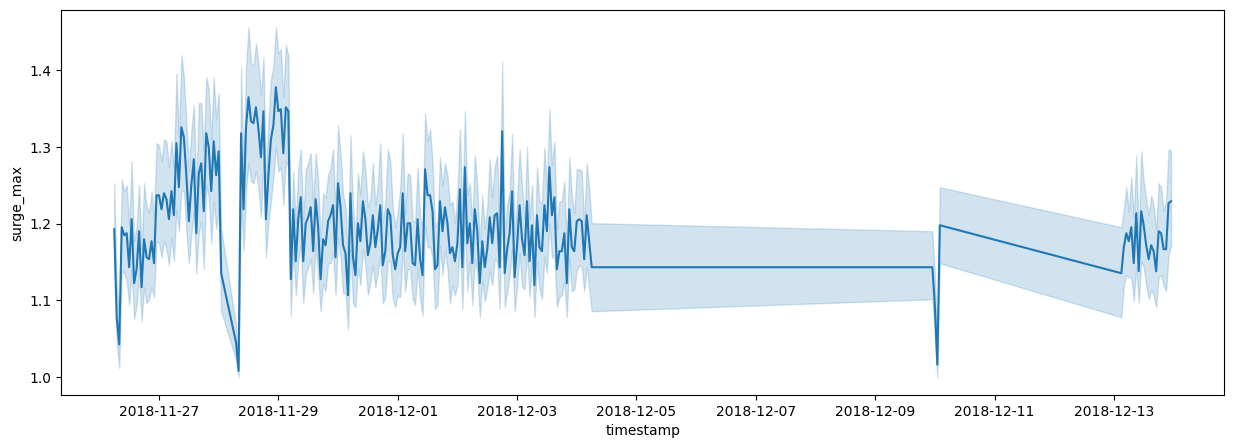

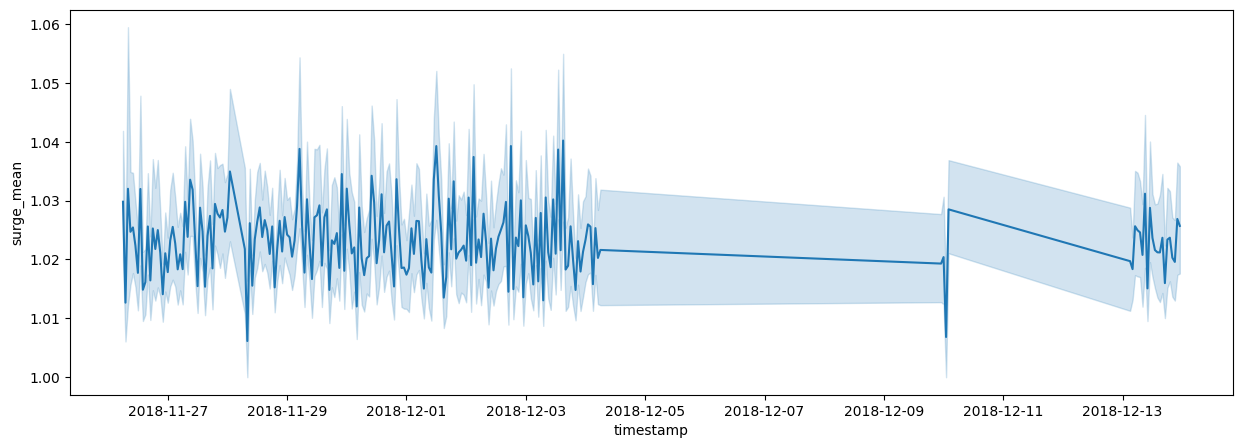

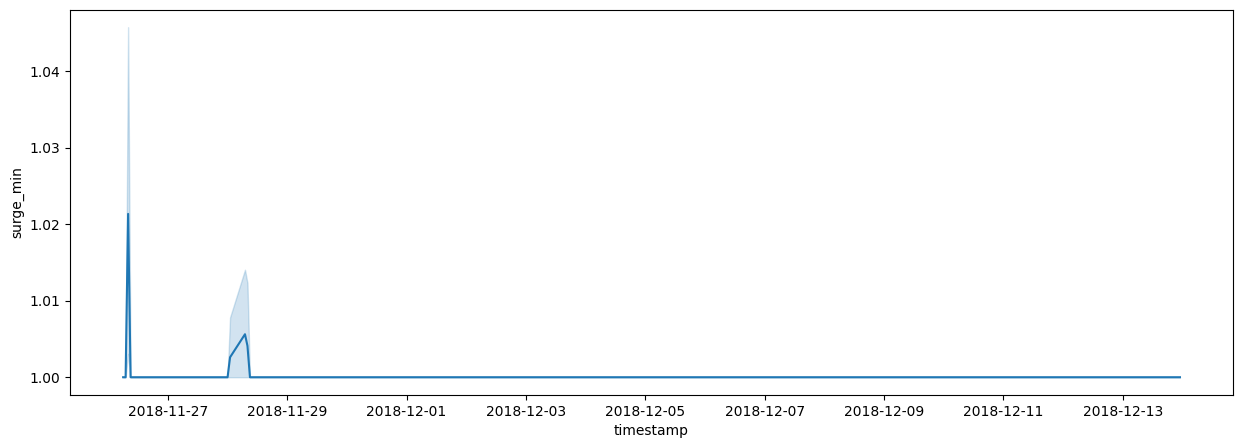

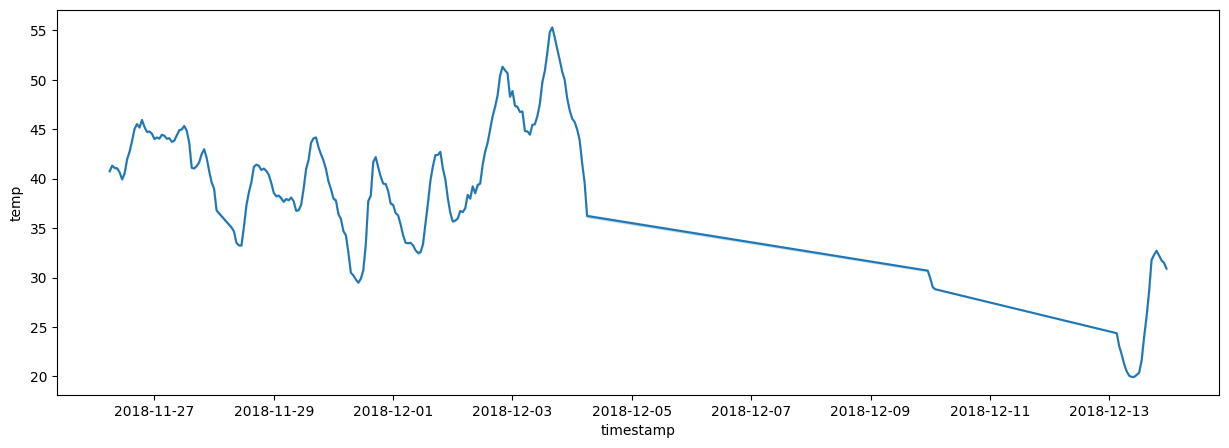

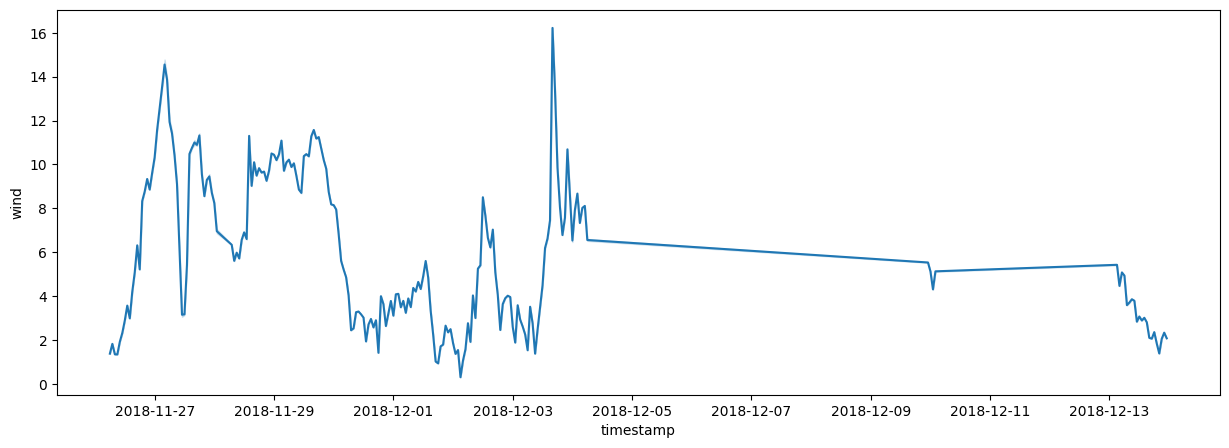

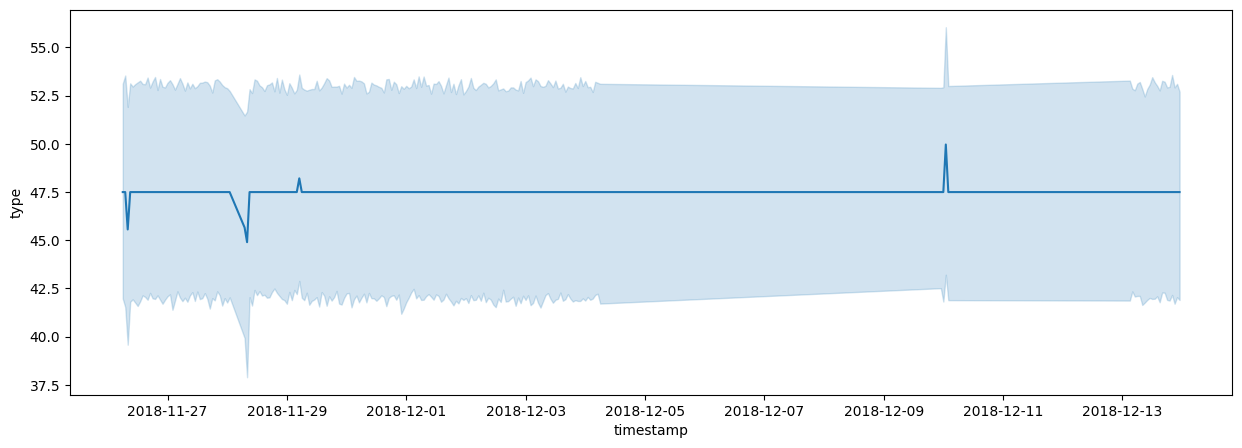

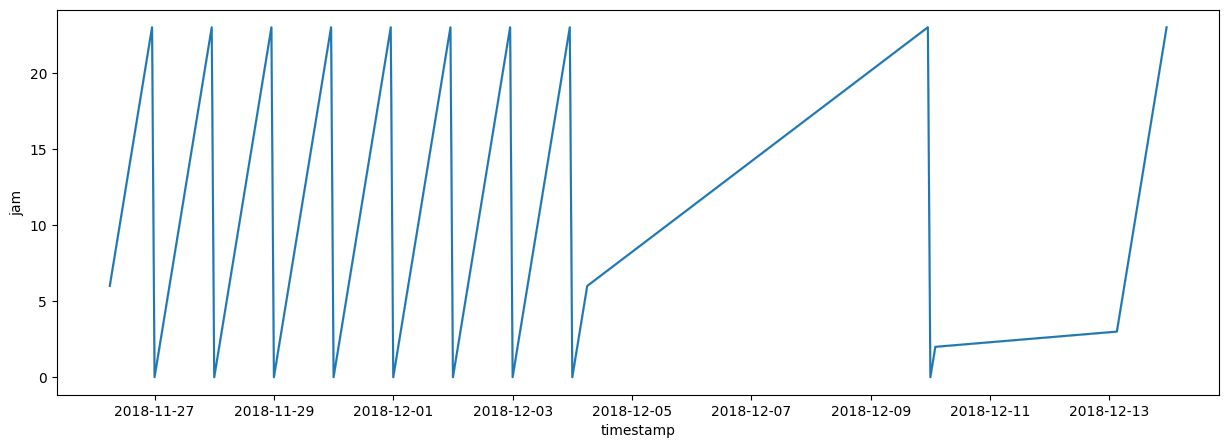

In [49]:
for i in train_df.drop(columns=['timestamp']):
    plt.figure(figsize=(15,5))
    sns.lineplot(data=train_df, x='timestamp', y=i)
    plt.show()

<Axes: >

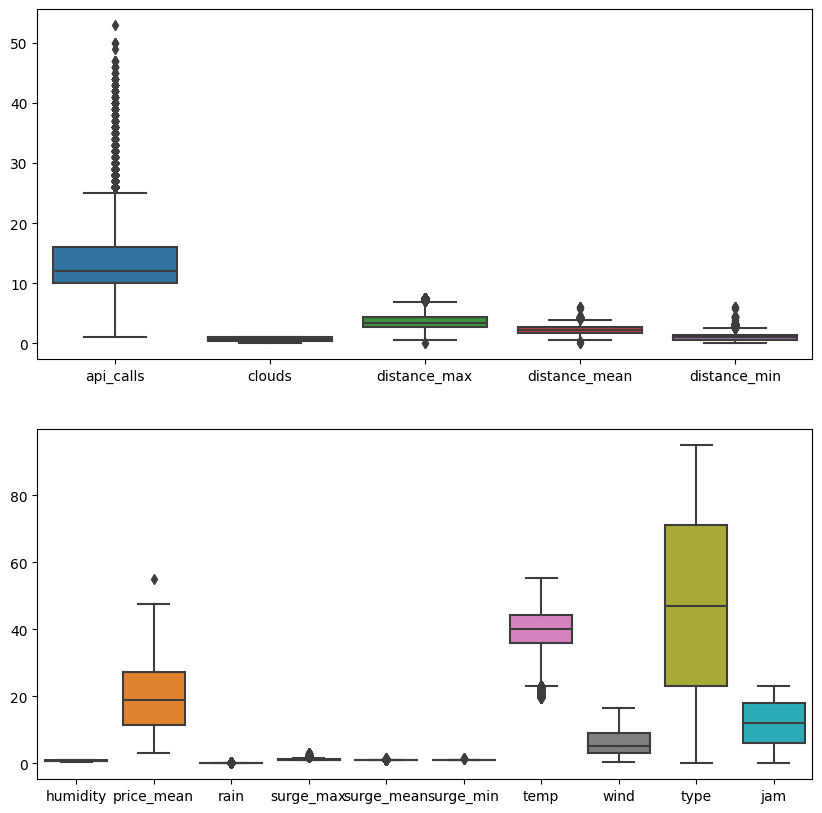

In [50]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.boxplot(train_df.iloc[:,:6], ax=ax[0])
sns.boxplot(train_df.iloc[:,6:], ax=ax[1])

## Scalling


In [51]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

X = train_df.drop(columns = ['timestamp', 'price_mean'])
y = pd.DataFrame(train_df.price_mean)

X_scaled = pd.DataFrame(scaler1.fit_transform(X), columns=X.columns)
y_scaled = pd.DataFrame(scaler2.fit_transform(y), columns=y.columns)

model_cv_comparison :
* linear_regression: 11.85524443260885
* lasso: 11.563291732076664
* ridge: 11.855016033571786
* svr: 12.178107803755426
* randomforest: 7.241188921427335
* gradientboosting: 7.445994294533927
* xgboost: 7.262961284438617
* catboost: 7.261268307429274
* lightgbm: 7.290047344222943

In [52]:
kfold_cv(cb.CatBoostRegressor(verbose = 0), X_scaled, y_scaled)

0.812174943096528

In [53]:
random_seed = 42
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_scaled, y_scaled, train_size=0.8, random_state = random_seed)
for name, model in models.items():
        model.fit(X_train1, y_train1)
        predictions = pd.DataFrame(model.predict(X_val1))
        score_scaled = mse(y_val1, predictions, squared=False)
        score_scaled_squared = mse(y_val1, predictions)
        hasil = pd.DataFrame(scaler2.inverse_transform(predictions), columns = ['price_mean'])
        asli = pd.DataFrame(scaler2.inverse_transform(y_val1), columns = ['price_mean'])
        score_asli = mse(asli['price_mean'], hasil['price_mean'], squared = False)
        score_asli_squared = mse(asli['price_mean'], hasil['price_mean'])
        print(f'{name}: {score_scaled} [{score_scaled_squared}]  | {score_asli} [{score_asli_squared}] ')
        
        #0.062425096813963014 

linear_regression: 0.958781675315723 [0.9192623009212244]  | 8.575393016490432 [73.53736538727287] 
Huber_regression: 0.9618467816432881 [0.925149231357551]  | 8.602807486408775 [74.00829664821087] 
lasso: 0.9583885425962649 [0.9185085985797928]  | 8.571876817063817 [73.47707216691612] 
ridge: 0.9587743658953046 [0.9192482846979434]  | 8.57532764065522 [73.53624414458541] 
svr: 0.7044611949704098 [0.49626557521913783]  | 6.300737453861401 [39.69929246249185] 
randomforest: 0.06880707012942783 [0.0047344128997959985]  | 0.6154140028581193 [0.37873439491385325] 
gradientboosting: 0.08698908950236144 [0.007567101692449848]  | 0.7780349268604532 [0.6053383474147508] 
xgboost: 0.06708400123037367 [0.004500263221076776]  | 0.600002787425671 [0.36000334491857494] 
catboost: 0.06266478140095837 [0.003926874828029898]  | 0.560477053995345 [0.3141345280553009] 
lightgbm: 0.064201295558289 [0.004121806351362779]  | 0.5742197162861871 [0.32972828257178916] 
MLPRegression: 0.25257776471576526 [0.06

## Recursive Feature Elimination


In [65]:
model = cb.CatBoostRegressor(verbose=0, random_state = random_seed)
rfe_dict = model.select_features(X = X_train1, 
                                     y = y_train1, 
                                     eval_set = (X_val1,y_val1), # Walkforward validation set we have created earlier
                                     features_for_select = '0-13', # Features that will be selected on the RFE
                                     num_features_to_select = 7, # Number of features to keep from the selected
                                     steps = 5, # Number of model iterations performed in the RFE
                                     verbose = 50, #
                                     algorithm = EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                     train_final_model = True, # Train final model after RFE is finished
                                     plot = True # plot the ??? after the RFE is finished
                                     )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.078912
Step #1 out of 5
0:	learn: 0.9331869	test: 0.9224997	best: 0.9224997 (0)	total: 8.65ms	remaining: 8.65s
50:	learn: 0.1209545	test: 0.1181533	best: 0.1181533 (50)	total: 444ms	remaining: 8.27s
100:	learn: 0.0855389	test: 0.0857217	best: 0.0857217 (100)	total: 850ms	remaining: 7.57s
150:	learn: 0.0743806	test: 0.0753193	best: 0.0753193 (150)	total: 1.28s	remaining: 7.21s
200:	learn: 0.0687059	test: 0.0702762	best: 0.0702762 (200)	total: 1.68s	remaining: 6.7s
250:	learn: 0.0653125	test: 0.0678752	best: 0.0678752 (250)	total: 2.1s	remaining: 6.28s
300:	learn: 0.0628231	test: 0.0662222	best: 0.0662211 (299)	total: 2.51s	remaining: 5.83s
350:	learn: 0.0611795	test: 0.0654302	best: 0.0654302 (350)	total: 2.93s	remaining: 5.41s
400:	learn: 0.0598474	test: 0.0648608	best: 0.0648608 (400)	total: 3.34s	remaining: 4.99s
450:	learn: 0.0586657	test: 0.0644697	best: 0.0644697 (450)	total: 3.72s	remaining: 4.53s
500:	learn: 0.0575718	test: 0.0641650	best: 0.0641650 (500)	

In [62]:
rfe_dict

{'selected_features': [2, 3, 4, 7, 8, 12],
 'eliminated_features_names': ['humidity',
  'clouds',
  'temp',
  'api_calls',
  'jam',
  'wind',
  'rain',
  'surge_min'],
 'loss_graph': {'main_indices': [0, 2, 3, 5, 6, 7, 8],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8],
  'loss_values': [0.06259557695877864,
   0.06211670015110926,
   0.061695032804748834,
   0.06240642768572078,
   0.062332822502625576,
   0.06228515874916674,
   0.06152725343431998,
   0.061680563605664686,
   0.06175432799577926]},
 'eliminated_features': [5, 1, 10, 0, 13, 11, 6, 9],
 'selected_features_names': ['distance_max',
  'distance_mean',
  'distance_min',
  'surge_max',
  'surge_mean',
  'type']}

In [66]:
X_train2 = X_train1[rfe_dict['selected_features_names']]
X_val2 = X_val1[rfe_dict['selected_features_names']]
X_train2

,distance_max,distance_mean,distance_min,surge_max,surge_mean,surge_min,type
12064,-0.277618,0.570048,0.873667,0.150284,0.287477,-0.018703,0.307250
5940,1.637956,0.004646,-1.168677,1.707833,0.702172,-0.018703,-0.703329
15852,1.071378,1.420302,0.993805,-0.628491,-0.541914,-0.018703,0.956908
12233,-0.250638,-0.495379,-0.788240,-0.628491,-0.541914,-0.018703,0.343342
19779,-0.115739,-0.840151,-0.948424,-0.628491,-0.541914,-0.018703,1.642658
...,...,...,...,...,...,...,...
11284,-1.410774,-1.919005,-1.188700,-0.628491,-0.541914,-0.018703,0.198974
11964,-0.286611,0.538141,0.533276,1.707833,2.941526,-0.018703,0.307250
5390,-1.042049,-0.644276,0.673437,0.929058,1.780379,-0.018703,-0.811605
860,1.476076,0.673275,0.333046,2.486607,4.434429,-0.018703,-1.569539


In [67]:
predictions = model.predict(X_val2)
print(mse(y_val1, predictions))
hasil = pd.DataFrame(scaler2.inverse_transform(pd.DataFrame(predictions)), columns = ['price_mean'])
asli = pd.DataFrame(scaler2.inverse_transform(y_val1), columns = ['price_mean'])
score_asli = mse(asli['price_mean'], hasil['price_mean'], squared = False)
score_asli
#0.003813596986690949
#0.552333908670911

0.0038044918969853702


0.5516741568476163

In [68]:
X_scaled1 = X_scaled[rfe_dict['selected_features_names']]
X_scaled1

,distance_max,distance_mean,distance_min,surge_max,surge_mean,surge_min,type
0,-0.484464,-0.751570,0.052725,0.929058,0.748249,-0.018703,-1.713908
1,-0.808223,-0.811785,0.152840,2.486607,1.780379,-0.018703,-1.713908
2,-1.968359,-1.320882,0.733506,-0.628491,-0.541914,-0.018703,-1.713908
3,-0.439498,-0.432576,0.753529,1.707833,2.097056,-0.018703,-1.713908
4,-0.502451,-0.101514,0.112794,0.929058,1.393330,-0.018703,-1.713908
...,...,...,...,...,...,...,...
20350,-0.160705,0.202618,-0.588011,-0.628491,-0.541914,-0.018703,1.714842
20351,-0.691310,-0.463264,-0.588011,-0.628491,-0.541914,-0.018703,1.714842
20352,-0.439498,-0.323217,-0.588011,-0.628491,-0.541914,-0.018703,1.714842
20353,-0.439498,0.421724,0.433161,-0.628491,-0.541914,-0.018703,1.714842


## Hyperparameter Tuning

In [71]:
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [1000, 2000, 3000]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy" : trial.suggest_categorical("grow_policy", ['Lossguide', 'Depthwise', 'SymmetricTree']),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "max_bin": trial.suggest_int("max_bin", 5, 255),
        "score_function": trial.suggest_categorical("score_function", ['Cosine', 'L2']),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ['Newton', 'Gradient']),
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 50),
        "loss_function" : 'RMSE'
    }
     
    model = cb.CatBoostRegressor(**params, silent=True, random_seed = random_seed)
    #score = kfold_cv(X_scaled1, y_scaled)
    model.fit(X_train2, y_train1, eval_set = [(X_val2, y_val1)])
    predictions = model.predict(X_val2)
    score = mse(y_val1, predictions)
    return score

sampler = TPESampler(seed=random_seed)
study = optuna.create_study(direction='minimize', sampler = sampler)
study.optimize(objective, n_trials=100)
best_params1 = study.best_params
best_params1

[I 2023-11-20 15:16:21,302] A new study created in memory with name: no-name-f94205a3-9dfb-462f-9ca2-4e0eb0afcef5
[I 2023-11-20 15:16:26,355] Trial 0 finished with value: 0.009513417871695283 and parameters: {'iterations': 2000, 'learning_rate': 0.015751320499779727, 'subsample': 0.19821770842031466, 'colsample_bylevel': 0.19819479431939252, 'min_data_in_leaf': 6, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.011527987128232402, 'max_bin': 248, 'score_function': 'Cosine', 'leaf_estimation_method': 'Gradient', 'max_depth': 5, 'early_stopping_rounds': 31}. Best is trial 0 with value: 0.009513417871695283.
[I 2023-11-20 15:16:41,622] Trial 1 finished with value: 0.010497358196162003 and parameters: {'iterations': 3000, 'learning_rate': 0.0019010245319870357, 'subsample': 0.3275374161084572, 'colsample_bylevel': 0.3980437511290071, 'min_data_in_leaf': 46, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.59874749104614, 'max_bin': 16, 'score_function': 'Cosine', 'leaf_estimation_method': 'Gradie

{'iterations': 2000,
 'learning_rate': 0.016692875871897158,
 'subsample': 0.8297955199463312,
 'colsample_bylevel': 0.9715830089818569,
 'min_data_in_leaf': 46,
 'grow_policy': 'SymmetricTree',
 'l2_leaf_reg': 0.9327976801532506,
 'max_bin': 201,
 'score_function': 'L2',
 'leaf_estimation_method': 'Gradient',
 'max_depth': 8,
 'early_stopping_rounds': 24}

In [76]:
best_params1_copy = {'iterations': 2000,
 'learning_rate': 0.016692875871897158,
 'subsample': 0.8297955199463312,
 'colsample_bylevel': 0.9715830089818569,
 'min_data_in_leaf': 46,
 'grow_policy': 'SymmetricTree',
 'l2_leaf_reg': 0.9327976801532506,
 'max_bin': 201,
 'score_function': 'L2',
 'leaf_estimation_method': 'Gradient',
 'max_depth': 8,
 "loss_function" : 'RMSE',
 'early_stopping_rounds': 24}

In [74]:
model = cb.CatBoostRegressor(**best_params1_copy, verbose = 0, random_seed = random_seed)
model.fit(X_train2, y_train1, eval_set = [(X_val2, y_val1)])
predictions = model.predict(X_val2)
print(mse(y_val1, predictions, squared=False))
print(mse(y_val1, predictions))
hasil = pd.DataFrame(scaler2.inverse_transform(pd.DataFrame(predictions)), columns = ['price_mean'])
score_asli = mse(asli['price_mean'], hasil['price_mean'], squared = False)
print(score_asli)

0.06061957469261019
0.0036747328359129456
0.5421846191526861


## Bagging

In [112]:
strain_full = []
stest_full = []
base_models = [cb.CatBoostRegressor(**best_params1_copy, verbose = 0, random_seed = random_seed)]
for i in range(5):
    S_train, S_test = stacking(base_models,                # list of base models
                               X_train2, y_train1, X_val2,   # data
                               regression = True,          # We need regression - set to True)
                               mode = 'oof_pred_bag',      # mode: oof for train set, predict test 
                                                           # set in each fold and vote
                               needs_proba = False,        # predict class labels (if you need 
                                                           # probabilities - set to True) 
                               save_dir = None,            # do not save result and log (to save 
                                                           # in current dir - set to '.')
                               metric = mse,# metric: callable
                               n_folds = 10,               # number of folds
                               stratified = False,         # stratified split for folds
                               shuffle = True,             # shuffle the data
                               random_state =  i,       # ensure reproducibility
                               verbose = 1)                # print progress
    strain_full.append(S_train)
    stest_full.append(S_test)
    print(f"{i+1} iteration done")
    
strain_full1 = np.mean(strain_full, axis = 0)
stest_full1 = np.mean(stest_full, axis = 0)

# Initialize 2nd level model
model = cb.CatBoostRegressor(**best_params1_copy, verbose = 0, random_seed = random_seed)
    
# Fit 2nd level model
model = model.fit(strain_full1, y_train1)

# Predict
y_pred = model.predict(stest_full1)

# Final prediction score
print('Final prediction score: [%.8f]' % mse(y_val1, y_pred, squared = False))

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00411045] + [0.00033352]
    FULL:     [0.00411047]

1 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00412631] + [0.00045461]
    FULL:     [0.00412627]

2 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00410788] + [0.00026072]
    FULL:     [0.00410788]

3 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00413539] + [0.00047841]
    FULL:     [0.00413538]

4 iteration done
task:         [regression]
metric:      

In [113]:
model = cb.CatBoostRegressor(**best_params1_copy, verbose = 0, random_seed = random_seed)
model.fit(strain_full1, y_train1)
predictions = model.predict(stest_full1)
print(mse(y_val1, predictions, squared=False))
print(mse(y_val1, predictions))
hasil = pd.DataFrame(scaler2.inverse_transform(pd.DataFrame(predictions)), columns = ['price_mean'])
score_asli = mse(asli['price_mean'], hasil['price_mean'], squared = False)
print(score_asli)

0.06252920513086824
0.003909901494298198
0.5592644528060807


## Submission

In [99]:
test_df = test_df.drop(columns=['index','timestamp'])
scaled_data = scaler1.transform(test_df)
scaled_df = pd.DataFrame(scaled_data,
                         columns=test_df.columns)
scaled_df = scaled_df[rfe_dict['selected_features_names']]

scaled_df.head()

,distance_max,distance_mean,distance_min,surge_max,surge_mean,surge_min,type
0,-0.493457,-0.335534,0.092771,2.486607,2.137655,-0.018703,-1.713908
1,-1.105002,-1.055776,0.052725,-0.628491,-0.541914,-0.018703,-1.713908
2,-0.511444,-0.285003,0.132817,0.929058,1.691060,-0.018703,-1.713908
3,-0.385538,-0.531235,0.092771,0.150284,-0.058103,-0.018703,-1.713908
4,-1.042049,-0.903282,0.092771,0.150284,0.287477,-0.018703,-1.713908


In [100]:
def final_model(model, X, y, test):
    test_strain = []
    test_stest = []
    base_models = [model]
    for i in range(5):
        S_train, S_test = stacking(base_models,                # list of base models
                                   X, y, test,   # data
                                   regression = True,          # We need regression - set to True)

                                   mode = 'oof_pred_bag',      # mode: oof for train set, predict test 
                                                               # set in each fold and vote
                                   needs_proba = False,        # predict class labels (if you need 
                                                               # probabilities - set to True) 
                                   save_dir = None,            # do not save result and log (to save 
                                                               # in current dir - set to '.')
                                   metric = mse,# metric: callable
                                   n_folds = 10,               # number of folds
                                   stratified = False,         # stratified split for folds
                                   shuffle = True,             # shuffle the data
                                   random_state =  i,       # ensure reproducibility
                                   verbose = 1)                # print progress

        test_strain.append(S_train)
        test_stest.append(S_test)
        print(f"{i+1} iteration done")

    final_prediction = np.mean(test_stest, axis = 0)
    return final_prediction

In [101]:
cb_model = cb.CatBoostRegressor(**best_params1_copy, verbose = 0, random_seed = 39, bagging_temperature = 400)    
prediction = final_model(cb_model, X_scaled1, y_scaled, scaled_df)
prediction

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00397016] + [0.00026462]
    FULL:     [0.00397017]

1 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00402849] + [0.00025709]
    FULL:     [0.00402850]

2 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00397596] + [0.00024546]
    FULL:     [0.00397595]

3 iteration done
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [0.00399734] + [0.00030044]
    FULL:     [0.00399736]

4 iteration done
task:         [regression]
metric:      

array([[-0.09840153],
       [-0.53449007],
       [-0.11876516],
       ...,
       [ 1.15530648],
       [ 1.11813737],
       [ 1.35549664]])

In [106]:
p = pd.DataFrame(scaler2.inverse_transform(prediction.reshape(-1,1)), columns=['price_mean'])
p.reset_index(inplace=True)

In [107]:
submission = p


submission.to_csv('submission.csv', index=False) 

In [108]:
submission.head(20)


,index,price_mean
0,0,18.459849
1,1,14.559451
2,2,18.277716
3,3,16.359247
4,4,15.601570
5,5,15.421144
6,6,14.462088
7,7,15.604060
8,8,18.365501
9,9,16.603160


## GForm Submission

In [109]:
import pickle
pickle.dump(final_model, open('model_kudanull.pkl', 'wb'))


In [110]:
final_train = y_scaled.join(X_scaled1)
final_train.to_csv("Train_kudanull.csv", index = False)

scaled_df.to_csv("test_kudanull.csv", index = False)